Practical Statistics for Coders - Part One
======
Inspired by Jake VanderPlas' talk titled [Statistics for Hackers](https://www.youtube.com/watch?v=Iq9DzN6mvYA) and John Rauser's talk [Statistics Without the Agonizing Pain](https://www.youtube.com/watch?v=5Dnw46eC-0o), I thought I'd explore the idea a bit further with a Python-first approach. The central thesis of these talks is: if you can code, you can do statistics. 

This made me think about when I first got into statistics a few years ago. I went through the free [OpenIntro Statistics eBook](https://www.openintro.org/stat/) (second edition at the time). It’s a very accessible book, but some things are a bit… let’s say, traditional. Like having to learn a whole list of rules and formulas, looking up values in frequency tables, etc. If you have access to a computer and can write a for loop (or a list comprehension), statistics can actually be much simpler than what these books may lead you to believe. 

I'll talk you through a couple of introductory examples in this post and plan to ramp up the complexity in future posts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, binom

%matplotlib inline

## Coin toss
Most of these things start with a coin toss example. I'll just follow suit because it's a good way to warm up.

Suppose that you have a coin and you want to determine if it's biased towards landing as heads when tossed. Before tossing it, you have no reason to think that it's biased, so you assume it's fair.

You decide to toss it 20 times and count the amount of heads. You're willing to let go of your initial assumption that it's *not* biased if the amount of heads you observed is very unlikely to have occured by chance. 

This is a hypothesis test. In a hypothesis test, you assume there is nothing going on - the coin is not biased (this is $H_0$) and you're looking for evidence to the contrary.

What's *very unlikely*? Let's say somebody else has done this same experiment a 100 times with a coin that has been proven to be completely fair. Even this fair coin will sometimes land as heads (much) more often than tails. This is purely due to chance. On average, you'd see 10 heads in 20 tosses. The outcomes of these experiments, taken together, form a *distribution*.

The result that you observe with the coin you're testing can be compared to this distribution. You decide that if the amount of heads that you observed with the coin you're testing, or something even more extreme (even more heads!), only occurred in less than 5% of the repeated experiments that form the distribution, the coin you used is likely not fair.

Now imagine that your coin came up with 15 heads. Let's see how often a fair coin would indeed come up with 15+ heads if you toss it 20 times. That "somebody else" I mentioned earlier can be a computer, and instead of 100 repeats a computer can easily repeat it 100,000 times.

In [3]:
n_simulations = 100000
n_tosses = 20
n_heads = 15

# Use np.random.choice to simulate coin tosses. A 1 counts as heads:
results = [sum(np.random.choice([0, 1], size=n_tosses)) 
           for _ in range(n_simulations)]
num_n_heads_or_more = len([r for r in results if r >= n_heads])

print("{} times out of {} we observed {} heads or more"
      .format(num_n_heads_or_more, n_simulations, n_heads))

1971 times out of 100000 we observed 15 heads or more


Let's see what this looks like:

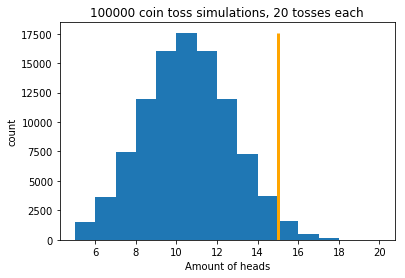

In [4]:
hist_min = 5
hist = plt.hist(results, bins=n_tosses - hist_min, range=(hist_min, n_tosses))
plt.vlines(n_heads, 0, max(hist[0]), color='orange', lw=3)
plt.title("{n_sim} coin toss simulations, {n_t} tosses each"
          .format(n_sim=n_simulations, n_t=n_tosses))
plt.xlabel("Amount of heads"); plt.ylabel("count"); 

The fraction of times that you saw 15 heads or more is what's called a p-value! This is the probability to observe the result of your experiment, or something more extreme than that, if the coin is unbiased (if $H_0$ is true).

In [5]:
p_value = num_n_heads_or_more / n_simulations
print(p_value)

0.02164


Only 2% of the time!

This is less than 5%, the **significance level** that you decided on initially. Now you can conclude that the coin is indeed biased: the probability of this (or something more extreme) happening by chance for an unbiased coin is very small.

What you would have done if you followed the textbook, is to take the binomial probability formula:

$ {\displaystyle \textstyle {n \choose k}\,p^{k}(1-p)^{n-k}}$

and sum the probabilities for every bin from 15 up to 20:

${\displaystyle \textstyle {20 \choose 15}\,\frac{1}{2}^{15}(1-\frac{1}{2})^{20-15}} +$

$ {\displaystyle \textstyle {20 \choose 16}\,\frac{1}{2}^{16}(1-\frac{1}{2})^{20-16}} + $

$ {\displaystyle \textstyle {20 \choose 17}\,\frac{1}{2}^{17}(1-\frac{1}{2})^{20-17}} + $

$ {\displaystyle \textstyle {20 \choose 18}\,\frac{1}{2}^{18}(1-\frac{1}{2})^{20-18}} + $

$ {\displaystyle \textstyle {20 \choose 19}\,\frac{1}{2}^{19}(1-\frac{1}{2})^{20-19} +} $

$ {\displaystyle \textstyle {20 \choose 20}\,\frac{1}{2}^{20}} \approx 0.0207 $

It's faster to directly use the formula for the Cumulative Distribution Function (CDF), but I haven't seen that one in my textbook. Either way, it seems like a lot more work than writing a for loop.

Of course, the `pmf()` function (Probability Mass Function) in the `scipy.stats.binom` module can be used to evaluate the function instead of doing the math manually like I did above. It accepts a list for variable `k` so you can compute multiple probabilities in one go:

In [6]:
sum(binom.pmf(n=n_tosses, k=[15,16,17,18,19,20], p=0.5))

0.020694732666015542

A faster way of doing that is just calling the Survial Function, which is 1-the CDF:

In [7]:
binom.sf(n=n_tosses, k=n_heads-1, p=0.5)

0.020694732666015625

So, here you go: 3 ways to compute the same answer. You can remember these functions if you like, but the point of this all is that you don't have to! As long as you can reason about how to data was generated in the first place and can write a simple for loop.

# Statistical significance of a mean

Suppose you want to find out if the average height of adults has increased. We are told that some time ago, it was normally distributed with a mean of 165 cm and a standard deviation of 20 cm. This is the null hypothesis, or $H_0$. We assume that this is still the case. $H_A$ is the alternative hypothesis, claiming that the average height increased.

You are handed a random sample of heights for adults, say n = 100 (assume the heights are independent and unbiased, i.e. representative of the general population).

In [8]:
# H0 values; we know this from a previous experiment:
μ = 165
σ = 20

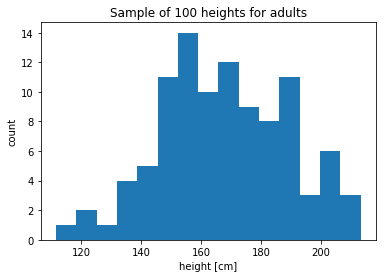

In [9]:
# Generate the random sample
μ_new = 170  # (we don't know this!)
σ_new = σ

np.random.seed(3)
n = 100
sample = norm.rvs(loc=μ_new, scale=σ_new, size=n)

plt.hist(sample, bins=15);
plt.title("Sample of {} heights for adults".format(n))
plt.xlabel("height [cm]"); plt.ylabel("count");

In [10]:
sample_mean = np.mean(sample)
sample_mean

167.8272585118788

This seems like it's more than 165. But we can't reject $H_0$ just yet. What we're seeing here might be due to random fluctuations.

We are still assuming that $H_0$ is true, so what we can do now is simulate taking a whole bunch of samples under the $H_0$ assumption and calculate the mean every time. Let's see what the distribution of means looks like:

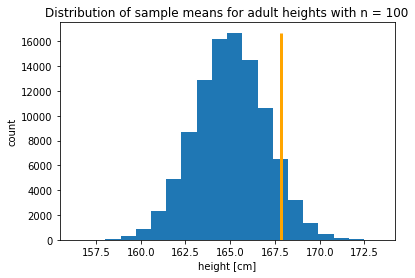

In [11]:
n_sims = 100000

means = [np.mean(norm.rvs(loc=μ, scale=σ, size=n)) for _ in range(n_sims)]
    
hist = plt.hist(means, bins=20);
plt.vlines(sample_mean, 0, max(hist[0]), color='orange', lw=3)
plt.title("Distribution of sample means for adult heights with n = {}".format(n))
plt.xlabel("height [cm]"); plt.ylabel("count");

Notice that this distribution is much narrower. 
A distribution such as this one is actually called a **sampling distribution** and is key to understanding these concepts.

Ok, now we proceed in the same way as before. How many of the means are $\geq$ the sample mean?

In [12]:
len([m for m in means if m >= sample_mean]) / n_sims

0.07868

Alright, so about 8% of the time we would see a result like the one we observed, or an even higher estimate.
Typically, $H_0$ won't get rejected because the value is larger than the traditional significance level of 0.05. The result isn't statistically significant. In other words, we simply don't have enough data to prove that 165 is wrong.

Of course, we *know* that it is wrong, because we simulated the sample with $\mu$=170. But remember that we normally don't know that this is the case. We got unlucky with the sample mean, because it ended up quite a bit lower than 170. If we double the sample size from 100 to 200, it would have been statistically significant (you can try this yourself).

Ok, now the textbook method:

We have to calculate something called a Z-score: 

$\displaystyle Z = \frac{\bar{x} - \mu}{\sigma} = \frac{167.827 - 165}{\sigma}$

The $\sigma$ we have to use here isn't the one that we knew initially for $H_0$, because that one relates to the entire distribution of heights. We need to use the $\sigma$ for the sample mean, the **standard error**. Statistics theory tells us that this can be approximated by:

$\displaystyle SE_\bar{x}  = \frac{\sigma}{\sqrt{n}} = \frac{20}{\sqrt{100}} = 2$

This is much lower than 20, which makes sense if you consider how narrow the distribution of means is.

The Z-score is: $\displaystyle \frac{167.827 - 165}{2} = 1.414$

Looking this up in a table yields 0.9207:

![Z-table](img/z_table.png)

Now you have to remember that this is the area on the left side. So 1 - 0.9207 = 0.0793 is our p-value. Which is close enough to the simulation.

Here's a quick Python shortcut that avoids using a probability table, again with the Survival Function:

In [13]:
# Inserted the Z-score; norm.sf() defaults to the standard normal distribution:
norm.sf(1.414)  

0.078680951241157648

In [14]:
# Inserted the sample mean; have to include H0 mean and Standard Error:
norm.sf(sample_mean, loc=μ, scale=σ/np.sqrt(n))  

0.078735393329218806

`scipy.stats.norm.sf()` is useful to remember if you do this a lot and don't want to write a loop every time. But I find that thinking about the data generation process and simulating that is a more natural way to handle these problems.

# Closing notes

The key takeaway here is the concept of generating the sampling distribution (under $H_0$), and then using that to reason about the probability of observing the thing you observed, assuming that $H_0$ is true. To generating the distribution, you need to have some theory about how the data was generated, i.e. a *generative model*. We had that in these examples, but we're not always this lucky! The next post in this series includes an example for a situation in which we don't have a generative model.